## Demo code for Bayesian inference

In this notebook we compare parametric and nonparametric Bayesian inference, 
to solidify concepts relating to the Dirichlet Process.

### Parametric Bayes

First, we illustrate the situation where the parameter $\theta$ that we are modeling is a Bernoulli parameter.
This can be thought of as the probability that flipping a certain coin comes up heads. The most commonly used prior distribution for this model is a beta distribution. Under a beta prior, the posterior distribution is again a beta distribution. 

This is illustrated in the following simulation. As the number of observed data points increases, this shows how the posterior becomes concentrated on the true parameter. But as the variance of the prior decreases, it takes longer and longer to converge to the true parameter.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import random
from scipy.stats import beta
from scipy.stats import norm
from IPython.display import clear_output
from time import sleep


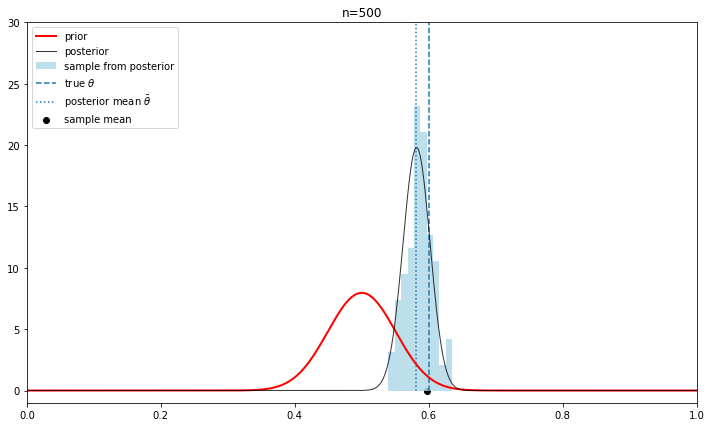

In [2]:
theta = np.linspace(0,1,num=500)

# The following are the parameters of the prior beta distribution. As the scale increases, the 
# variance of the prior decreases. We can see how this results in a larger amount of data required for 
# the posterior to be centered on the true parameter

scale = 50
a0 = scale*1
b0 = scale*1

sample_size = 100
p = 0.6
prior = beta.pdf(theta, a0, b0)

for n in np.arange(0, 501, 20):
    # sample from a coin with probability of heads p
    x = random.multinomial(n, pvals=[p, 1-p])
    
    # calculate the posterior alpha and beta parameters
    a = a0 + x[0]
    b = b0 + x[1]
    posterior = beta.pdf(theta, a, b)
    postmean = a/(a+b)
    
    # sample from the posterior
    posterior_sample = np.random.beta(a, b, size=sample_size)
    
    # plot everything
    clear_output(wait=True)
    plt.figure(figsize=(12,7))
    plt.title('n=%d' % n)
    plt.plot(theta, prior, linewidth=2, color='red', label='prior')
    plt.plot(theta, posterior, linewidth=1, color='black', alpha=.8, label='posterior')
    plt.xlim((0, 1))
    plt.ylim((-1,30))
    plt.hist(posterior_sample, density=True, color='lightblue', alpha=.8, label='sample from posterior')
    plt.vlines([p], ymin=0, ymax=30, linestyles='dashed', label=r'true $\theta$')
    plt.vlines([postmean], ymin=0, ymax=30, linestyles='dotted', label=r'posterior mean $\bar\theta$')
    plt.scatter([x[0]/n], [0], color='black', label='sample mean')
    plt.legend(loc='upper left')
    plt.show()
    sleep(.2)



### Nonparametric Bayes

Next, we sample from the posterior Dirichlet process, for a range of values 
of $\alpha$. Our data set is a small number of samples from a $N(5,3)$ distribution,. Note that the base distribution $F_0$, which is $N(0,1)$, is very different from the true distribution $N(5,3)$. So, for large $\alpha$ the posterior is very far from the true model; for small $\alpha$ the posterior becomes closer to the empirical distribution of the data.

Below we define three "helper" functions.

Given a parameter $\alpha$, the `stick_break` function returns a set of weights $w_1, w_2, \ldots, w_N$ given by

$$ w_i = 
\begin{cases} V_0 & \text{if $i=0$} \\
V_i (1-V_{i-1}) \cdots (1-V_{0}) & \text{if $i > 0$}
\end{cases} $$

where the random variables $V_0, V_1, \ldots, V_N$ are independent draws from a Beta$(1,\alpha)$ distribution. This gives a set of weights that sums to one (if $N$ is large).

In [3]:
def stick_break(alpha, N):
    V = np.random.beta(1, alpha, size=N)
    w = np.zeros(N)
    w[0] = V[0]
    d = 1
    for i in np.arange(1, N):
        d = d*(1-V[i-1])
        w[i] = V[i]*d
    return w/np.sum(w)

The next function, `sample_dirichlet_process(alpha, mu, sigma)` uses the stick breaking construction to draw a distribution $F$ from the prior $DP(\alpha, N(\mu, \sigma^2))$. To do this, we do two things:

1. Generate stick breaking weights $w_1, w_2, \ldots w_N$
2. Independently sample $s_1, s_2, \ldots, s_N$ from a $N(\mu,\sigma^2)$ distribution

After sorting the $s$ values, the resulting $F$ is then just a step function where 
there is a step of size $w_i$ at each value $s_i$.


In [4]:
def sample_dirichlet_process(alpha, mu, sigma):
    N = 1000
    s = np.random.normal(loc=mu, scale=sigma, size=N)
    w = stick_break(alpha, N)
    ind = np.argsort(s)
    s = s[ind]
    w = w[ind]
    return s, w

Our third function is `sample_dirichlet_process_posterior(x, alpha, mu, sigma)`, which 
samples from the posterior distribution $p(F \, |\, x_1, \ldots, x_n)$ when the prior distribution 
on $F$ is a Dirichlet process $DP(\alpha, N(\mu, \sigma^2))$. The sampling procedure 
is almost the same as for the prior, with a slight twist:

1. Generate stick breaking weights $w_1, w_2, \ldots w_N$ using the parameter $\tilde \alpha = \alpha + n$.

2. Independently sample $s_1, s_2, \ldots, s_N$ according to a mixture:
* With probability $\frac{\alpha}{\alpha + n}$, draw a sample from $F_0 = N(\mu,\sigma^2)$
* With probability $1 - \frac{\alpha}{\alpha + n}$, draw a sample from $\{x_1,\ldots, x_n\}$ (with replacement).

In [5]:
def sample_dirichlet_process_posterior(x, alpha, mu, sigma):
    N = 1000
    n = len(x)
    s0 = np.random.normal(loc=mu, scale=sigma, size=N)
    s1 = np.random.choice(x, size=N, replace=True)
    w = stick_break(alpha+n, N)
    b = np.random.binomial(1, p=alpha/(alpha+n), size=N)
    s = b*s0 + (1-b)*s1
    ind = np.argsort(s)
    s = s[ind]
    w = w[ind]
    return s, w

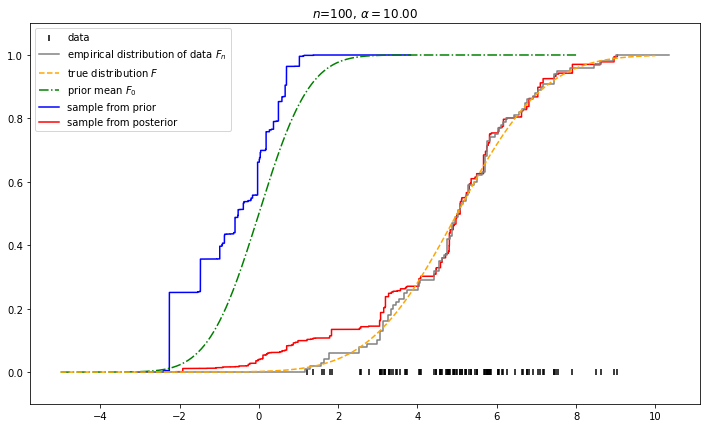

In [6]:
n = 15
mu = 5
sigma = np.sqrt(3)
eps = np.sqrt((1/(2*n))*np.log(2/.05)) # width of frequentist 95% interval

mu0 = 0
sigma0 = np.sqrt(1)

x = np.random.normal(loc=mu, scale=sigma, size=n)

xmin, xmax = norm.ppf([.001, 1-.001], loc=mu, scale=sigma)
xmin0, xmax0 = norm.ppf([.001, 1-.001], loc=mu0, scale=sigma0)
xmin = np.min([xmin, xmin0])
xmax = np.max([xmax, xmax0])


np.random.seed(1)
alpha = 10
trials = 10

#for n in np.arange(1, 20, 1):
for n in [1, 3, 5, 7, 10, 15, 20, 100]:
    for t in np.arange(trials):
        clear_output(wait=True)
        plt.figure(figsize=(12,7))
        x = np.random.normal(loc=mu, scale=sigma, size=n)
        
        s0 = np.linspace(xmin, xmax, 200)
        Fhat = np.zeros(len(s0))
        for i in np.arange(len(s0)):
            Fhat[i] = np.mean(x <= s0[i])

        s, w = sample_dirichlet_process_posterior(x, alpha=alpha, mu=mu0, sigma=sigma0)
        plt.step(s, np.cumsum(w), label='sample from posterior', color='red')

        s, w = sample_dirichlet_process(alpha=alpha, mu=mu0, sigma=sigma0)
        plt.step(s, np.cumsum(w), label='sample from prior', color='blue')

        plt.step(s0, Fhat, color='gray', label=r'empirical distribution of data $F_n$')
   
        xs = np.linspace(-5, 8, 500)
        plt.plot(xs, norm.cdf(xs, loc=mu0, scale=sigma0), linestyle='dashdot', color='green', label=r'prior mean $F_0$')

        xs = np.linspace(-5, 10, 500)
        plt.plot(xs, norm.cdf(xs, loc=mu, scale=sigma), linestyle='dashed', color='orange', label=r'true distribution $F$')

        plt.ylim((-.1, 1.1))
        plt.scatter(x, np.zeros(len(x)), marker='|', color='black', label='data')
        
        handles, labels = plt.gca().get_legend_handles_labels()
        order = [5,2,4,3,1,0]
        plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='upper left')

        plt.title(r'$n$=%d, $\alpha=$%.2f' % (n, alpha))
        plt.show()
        sleep(.2)
    
